In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from publish import *
from scipy import stats

# MEAT DATA TRAJECTORY

In [3]:
production = pd.read_csv("Datathon Data/Meat_Stats_Meat_Production.csv")

In [4]:
# Formatting the dataset, as in MeatDataScraping.ipynb
production["Production"] = production["Production"].apply(lambda x: x if type(x) == float else float(x.replace(",", "")))
production["Time"] = production["Year"] + (production["Month"] - 1) / 12

In [5]:
for unit in production["Unit"].values:
    if unit != "Million Pounds":
        print("INCONSISTENT UNITS")

In [6]:
# Hence, we can drop the units and define the unit as a global const
PRODUCTION_UNIT = "Million Pounds"

In [7]:
# Furthermore, as animals is a subset of red meat/poultry, we can drop that column and define these categories as sets
RED_MEATS = set()
POULTRY = set()

for _, row in production[["Animal", "Type of Meat"]].iterrows():
    if row["Type of Meat"] == "Red Meat":
        RED_MEATS.add(row["Animal"])
    else:
        POULTRY.add(row["Animal"])

RED_MEATS, POULTRY

({'Beef', 'Lamb and Mutton', 'Pork', 'Veal'},
 {'Broilers', 'Other Chicken', 'Turkey'})

In [8]:
production = production.drop(["Date", "Year", "Month", "Unit", "Type of Meat"], axis=1)

production

,Production,Animal,Commercial or Federally Inspected,Time
0,2189.8,Beef,Commercial,2023.916667
1,2280.9,Beef,Commercial,2023.833333
2,2340.9,Beef,Commercial,2023.750000
3,2149.4,Beef,Commercial,2023.666667
4,2363.5,Beef,Commercial,2023.583333
...,...,...,...,...
13590,NaN,Turkey,Federally Inspected,1921.333333
13591,NaN,Turkey,Federally Inspected,1921.250000
13592,NaN,Turkey,Federally Inspected,1921.166667
13593,NaN,Turkey,Federally Inspected,1921.083333


In [9]:
meats = production["Animal"].unique()
production_type = production["Commercial or Federally Inspected"].unique()

meats, production_type

(array(['Beef', 'Veal', 'Pork', 'Lamb and Mutton', 'Broilers',
        'Other Chicken', 'Turkey'], dtype=object),
 array(['Commercial', 'Federally Inspected'], dtype=object))

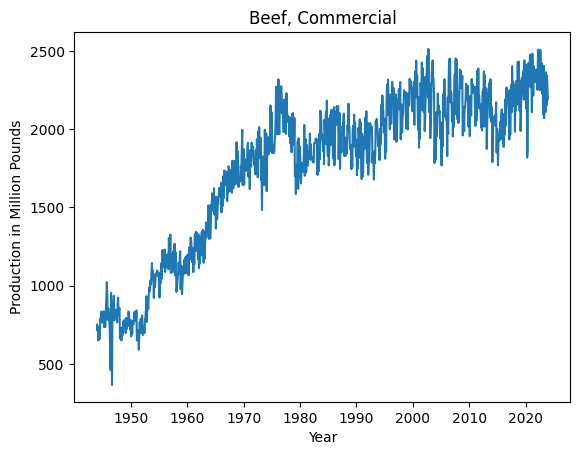

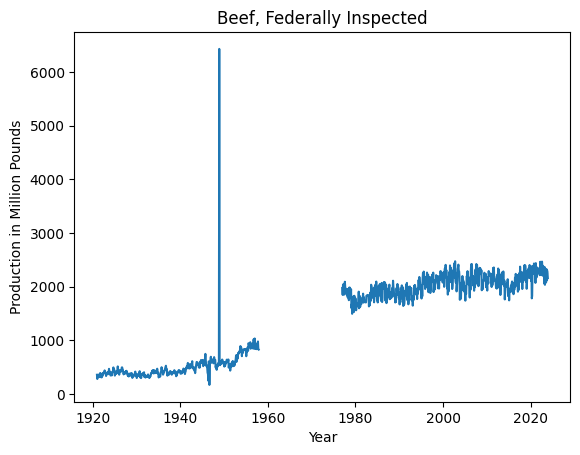

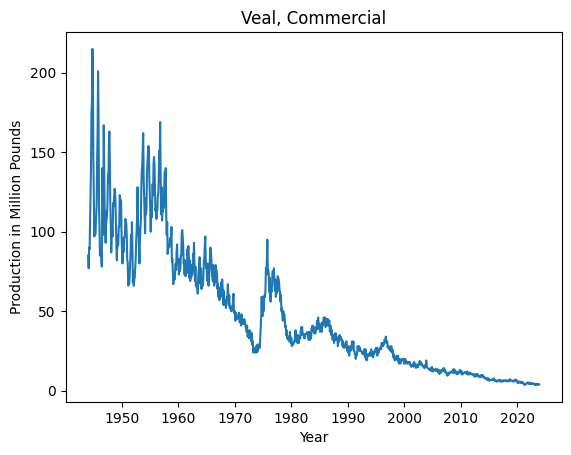

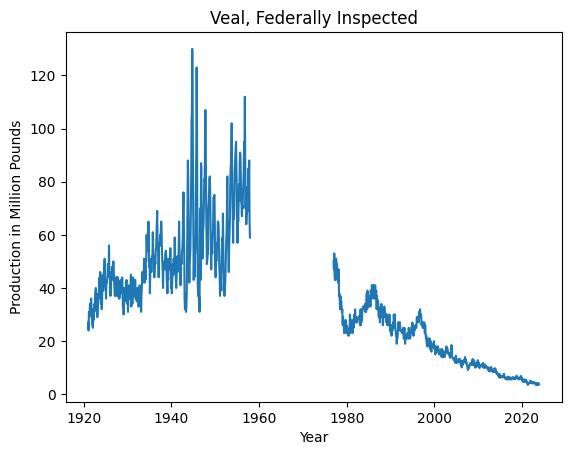

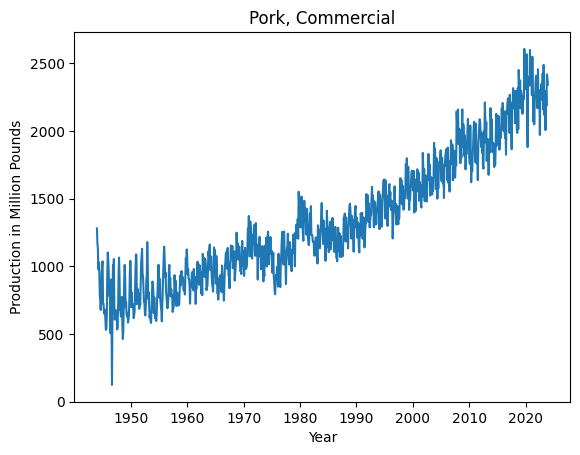

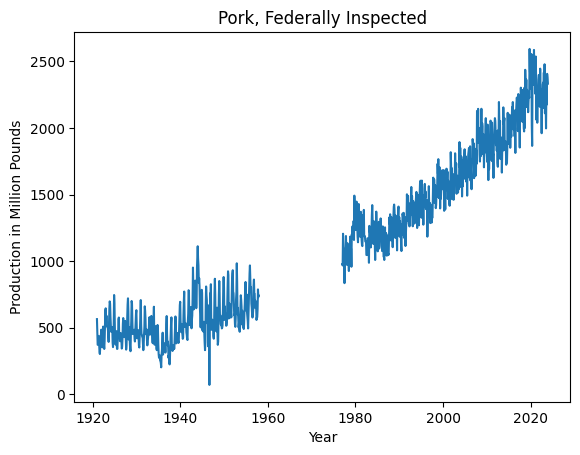

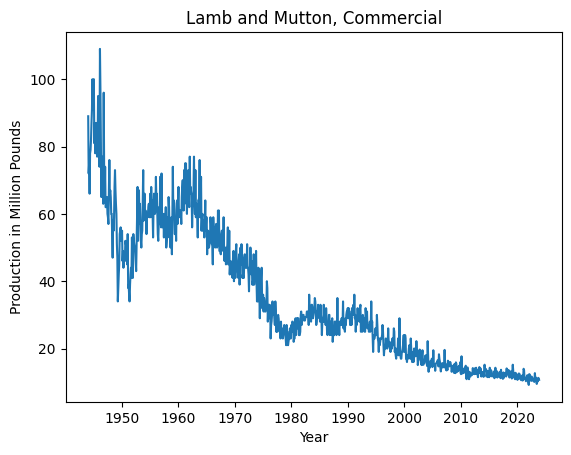

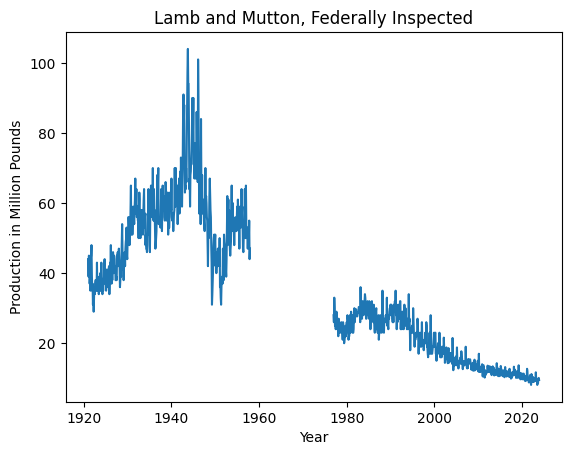

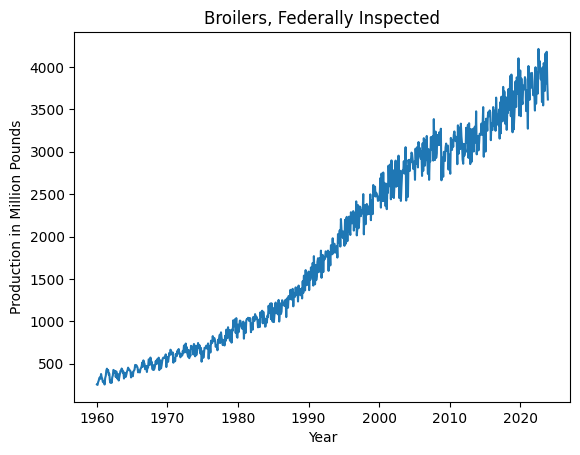

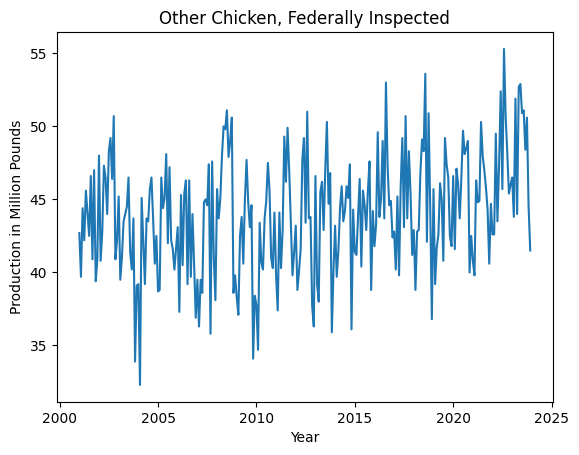

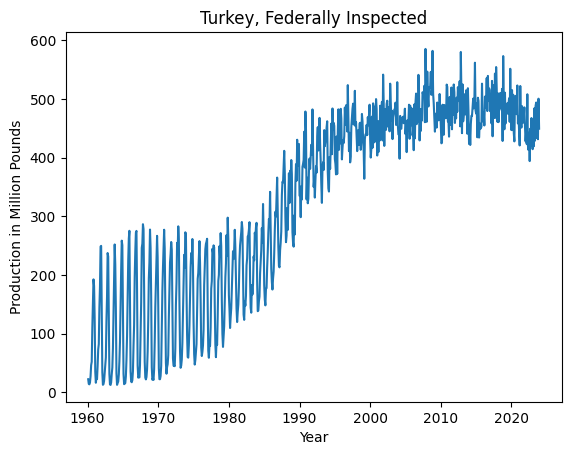

In [10]:
production_dfs = {}

for meat in meats:
    for prod in production_type:
        temp_df = production[(production["Animal"] == meat) & (production["Commercial or Federally Inspected"] == prod)].reset_index().drop(["index"], axis=1)

        if len(temp_df) == 0:
            continue

        # This code block explained in MeatDataScraping.ipynb
        for i in range(1, len(temp_df) - 1):
            if temp_df.at[i, "Production"] > 2 * temp_df.at[i - 1, "Production"]:
                if pd.isnull(temp_df.at[i + 1, "Production"]) and pd.isnull(temp_df.at[i + 2, "Production"]):
                    temp_df.at[i + 2, "Production"] = temp_df.at[i, "Production"] / 3
                    temp_df.at[i + 1, "Production"] = temp_df.at[i, "Production"] / 3
                    temp_df.at[i, "Production"] /=3

        # Turkey, Federally Inspected dataset has an error
        if (meat, prod) == ("Turkey", "Federally Inspected"):
            temp_df = temp_df.drop(temp_df[temp_df["Time"] < 1940].index)

        # This information is held in the name of the dataframe
        temp_df = temp_df.drop(["Animal", "Commercial or Federally Inspected"], axis=1)

        production_dfs[f"{meat}, {prod}"] = temp_df


        plt.gcf()
        plt.plot(temp_df["Time"].values, temp_df["Production"].values)
        plt.title(f"{meat}, {prod}")
        plt.xlabel("Year")
        plt.ylabel(f"Production in {PRODUCTION_UNIT}")
        plt.show()

## Linear Regression Analysis

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
# Arbitrary values, more to follow after Arav's analysis
START_TIME = 2001 # MUST BE BIGGER THAN 2001, to avoid dealing with NA values
VEGAN_START_TIME = 2017

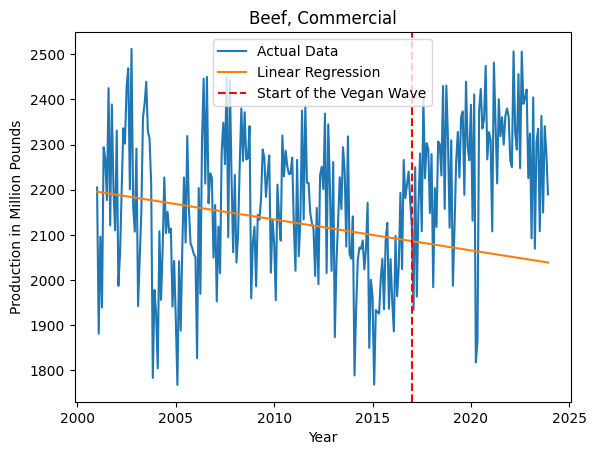

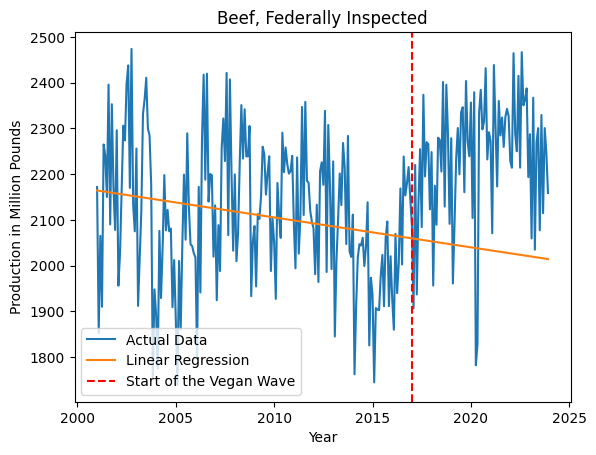

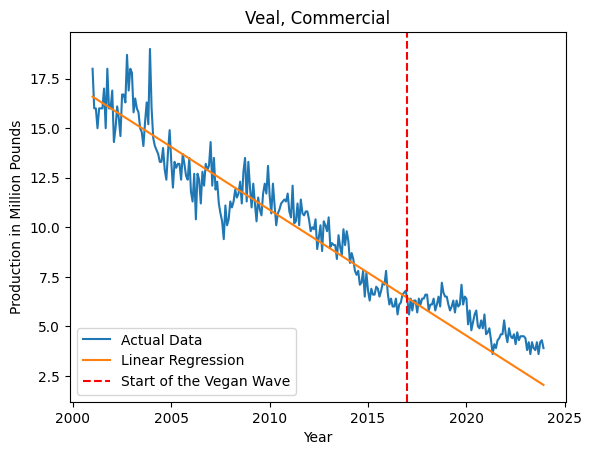

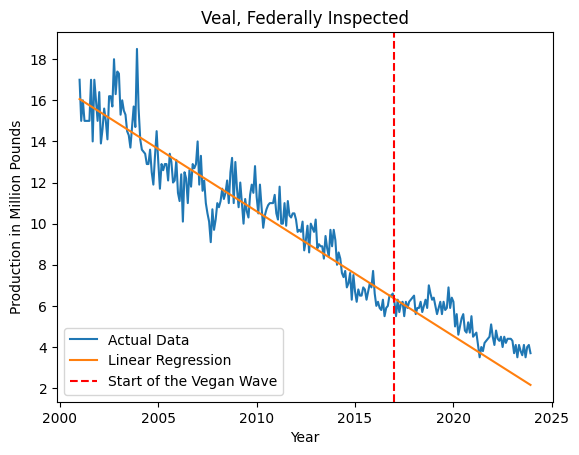

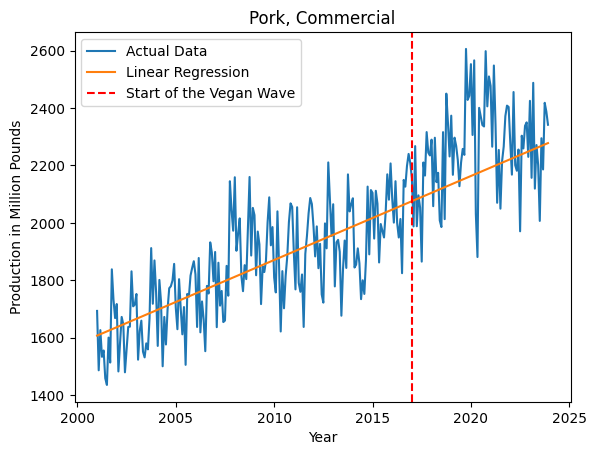

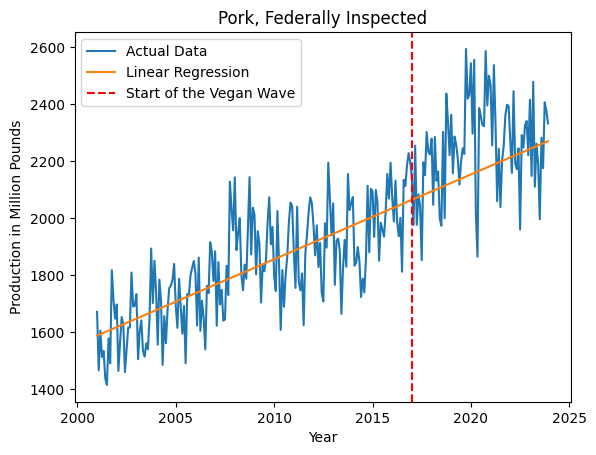

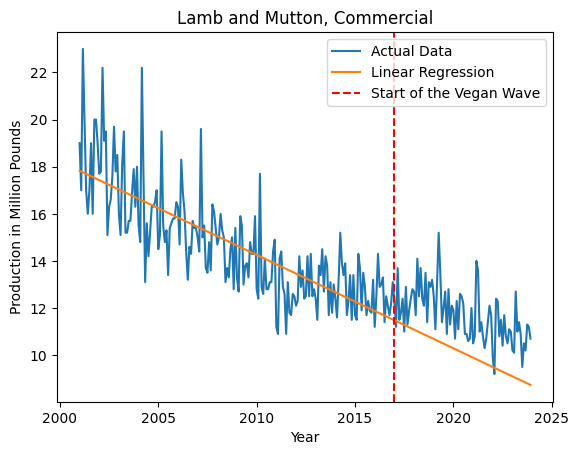

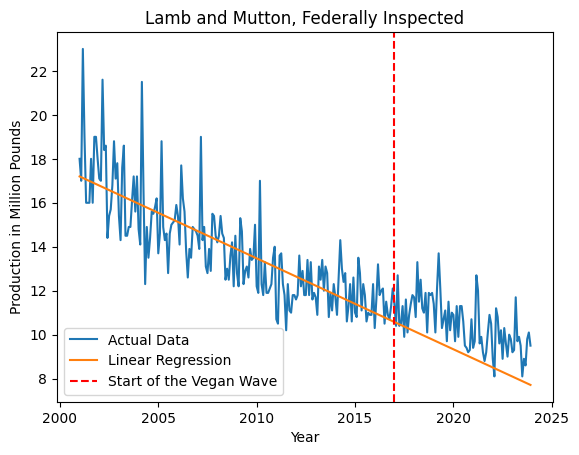

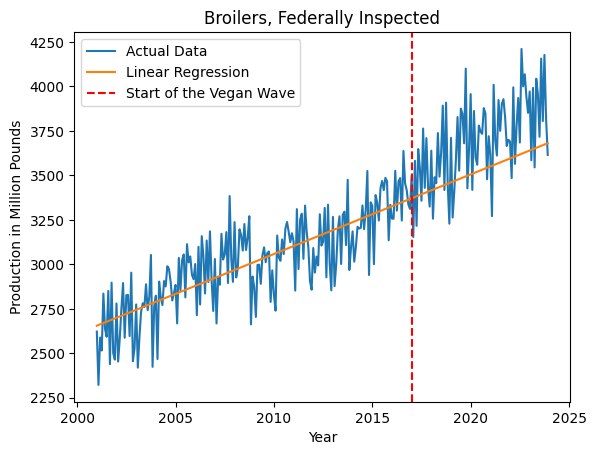

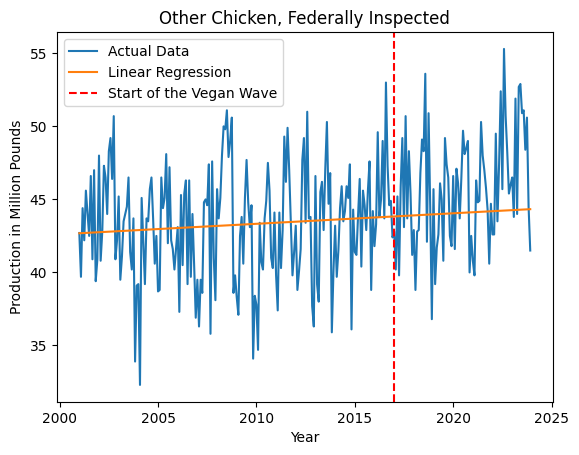

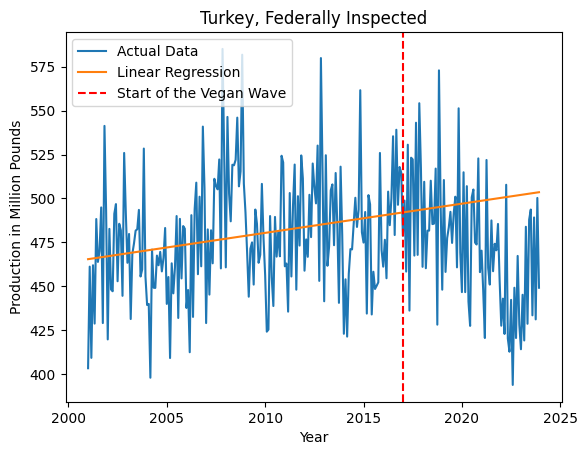

In [13]:
for label in production_dfs:
    xs = production_dfs[label][(production_dfs[label]["Time"] <= VEGAN_START_TIME) & (production_dfs[label]["Time"] >= START_TIME)]["Time"].values.reshape(-1, 1)
    ys = production_dfs[label][(production_dfs[label]["Time"] <= VEGAN_START_TIME) & (production_dfs[label]["Time"] >= START_TIME)]["Production"].values

    if any(pd.isnull(ys)): # This won't be needed if START TIME >= 2001
        continue

    linear_model = LinearRegression()
    linear_model.fit(xs, ys)

    gradient = linear_model.coef_
    intercept = linear_model.intercept_

    plot_xs = production_dfs[label][(production_dfs[label]["Time"] >= START_TIME)]["Time"].values
    plot_ys = production_dfs[label][(production_dfs[label]["Time"] >= START_TIME)]["Production"].values

    plt.gcf()
    plt.plot(plot_xs, plot_ys, label="Actual Data")
    plt.plot(plot_xs, gradient * plot_xs + intercept, label="Linear Regression")
    plt.axvline(VEGAN_START_TIME, color='red', linestyle="--", label="Start of the Vegan Wave")
    plt.title(label)
    plt.xlabel("Year")
    plt.ylabel(f"Production in {PRODUCTION_UNIT}")
    plt.legend()
    plt.show()

#### Results from individual categories seem insignificant

In [14]:
production_dfs_animal = {}

for label in production_dfs:
    animal, _ = label.split(",")

    if animal not in production_dfs_animal:
        production_dfs_animal[animal] = production_dfs[label][production_dfs[label]["Time"] >= START_TIME]
    else:
        production_dfs_animal[animal].loc[:, "Production"] = production_dfs_animal[animal]["Production"].values + production_dfs[label][production_dfs[label]["Time"] >= START_TIME]["Production"].values 

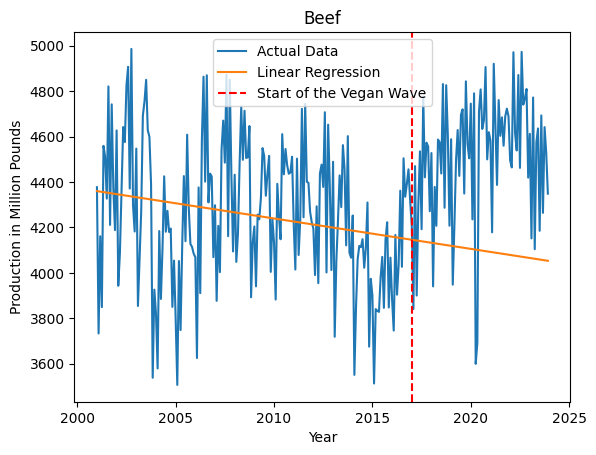

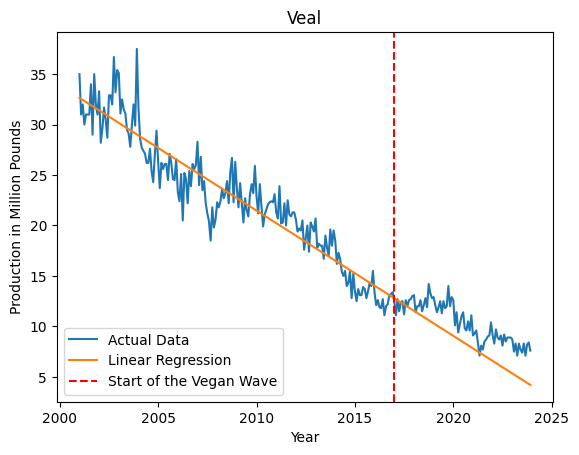

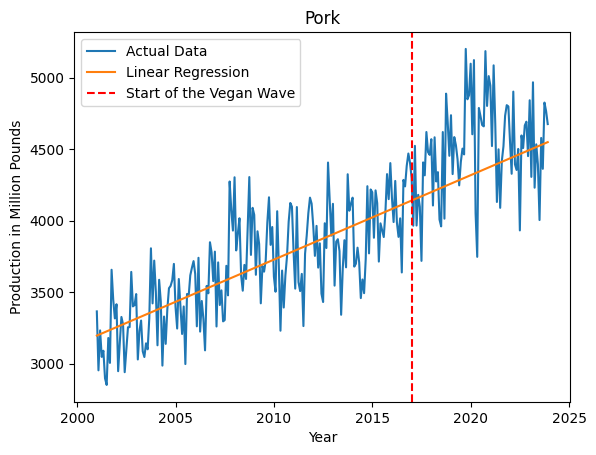

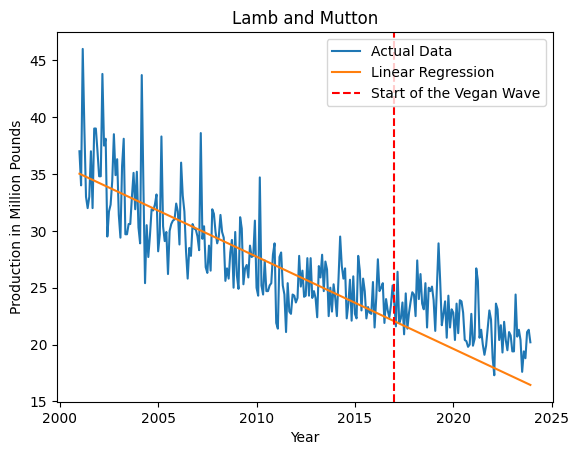

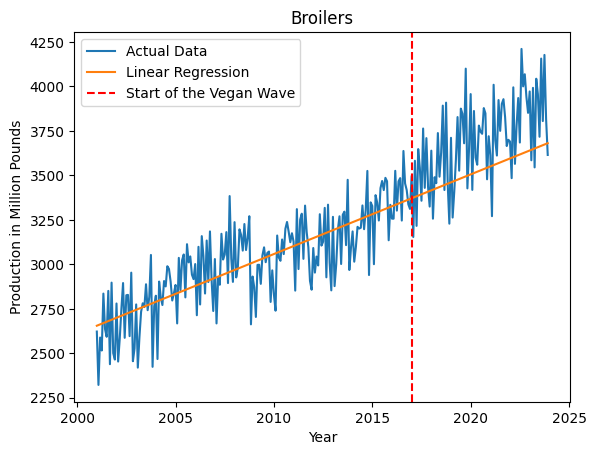

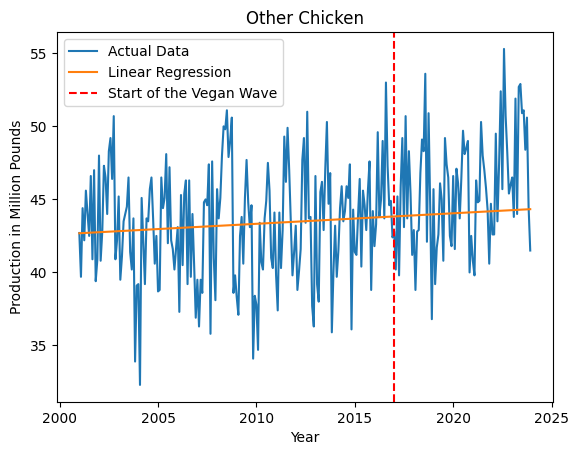

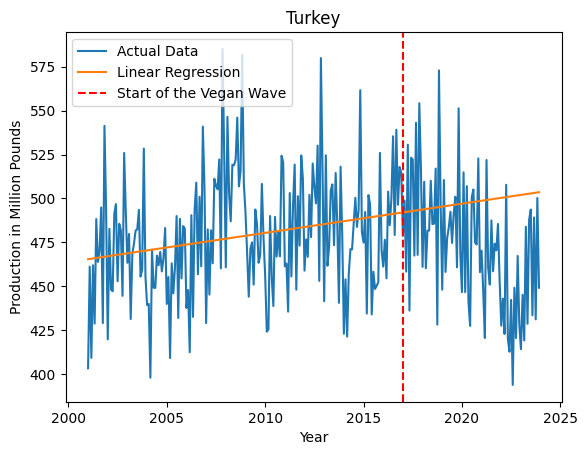

In [22]:
for label in production_dfs_animal:
    xs = production_dfs_animal[label][(production_dfs_animal[label]["Time"] <= VEGAN_START_TIME) & (production_dfs_animal[label]["Time"] >= START_TIME)]["Time"].values.reshape(-1, 1)
    ys = production_dfs_animal[label][(production_dfs_animal[label]["Time"] <= VEGAN_START_TIME) & (production_dfs_animal[label]["Time"] >= START_TIME)]["Production"].values

    if any(pd.isnull(ys)): # This won't be needed if START TIME >= 2001
        continue

    linear_model = LinearRegression()
    linear_model.fit(xs, ys)

    gradient = linear_model.coef_
    intercept = linear_model.intercept_

    plot_xs = production_dfs_animal[label][(production_dfs_animal[label]["Time"] >= START_TIME)]["Time"].values
    plot_ys = production_dfs_animal[label][(production_dfs_animal[label]["Time"] >= START_TIME)]["Production"].values

    plt.gcf()
    plt.plot(plot_xs, plot_ys, label="Actual Data")
    plt.plot(plot_xs, gradient * plot_xs + intercept, label="Linear Regression")
    plt.axvline(VEGAN_START_TIME, color='red', linestyle="--", label="Start of the Vegan Wave")
    plt.title(label)
    plt.xlabel("Year")
    plt.ylabel(f"Production in {PRODUCTION_UNIT}")
    plt.legend()
    plt.show()

#### Seems insignificant, bar Turkey and Beef

In [23]:
total_df = []

for animal in production_dfs_animal:
    if len(total_df) == 0:
        total_df = production_dfs_animal[animal][production_dfs_animal[animal]["Time"] >= START_TIME]
    else:
        total_df.loc[:, "Production"] = total_df["Production"].values + production_dfs_animal[animal][production_dfs_animal[animal]["Time"] >= START_TIME]["Production"].values

total_df

,Production,Time
0,13156.6,2023.916667
1,13685.6,2023.833333
2,14154.8,2023.750000
3,12994.7,2023.666667
4,13939.4,2023.583333
...,...,...
271,11023.0,2001.333333
272,9984.9,2001.250000
273,10513.3,2001.166667
274,9574.1,2001.083333


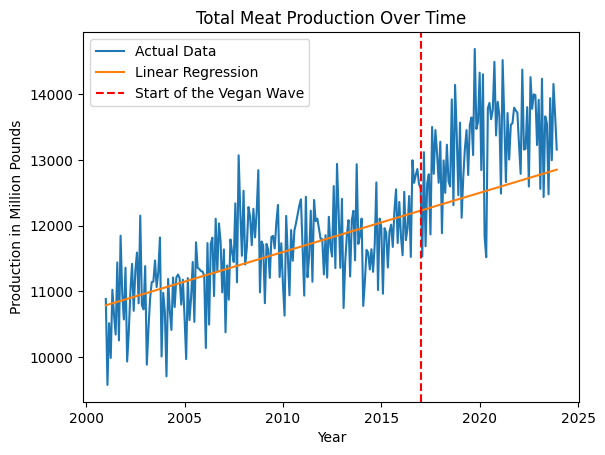

In [17]:
xs = total_df[total_df["Time"] <= VEGAN_START_TIME]["Time"].values.reshape(-1, 1)
ys = total_df[total_df["Time"] <= VEGAN_START_TIME]["Production"].values

linear_model = LinearRegression()
linear_model.fit(xs, ys)

gradient = linear_model.coef_
intercept = linear_model.intercept_

plot_xs = total_df["Time"].values
plot_ys = total_df["Production"].values

plt.gcf()
plt.plot(plot_xs, plot_ys, label="Actual Data")
plt.plot(plot_xs, gradient * plot_xs + intercept, label="Linear Regression")
plt.axvline(VEGAN_START_TIME, color='red', linestyle="--", label="Start of the Vegan Wave")
plt.title("Total Meat Production Over Time")
plt.xlabel("Year")
plt.ylabel(f"Production in {PRODUCTION_UNIT}")
plt.legend()
plt.show()

#### per capita production has roughly 0 slope. but does this mean we can consider raw values instead of differences? if so, use this; otherwise use below

In [18]:
pre_vegan_totals = total_df[total_df["Time"] < VEGAN_START_TIME]["Production"].values
post_vegan_totals = total_df[total_df["Time"] >= VEGAN_START_TIME]["Production"].values

pre_vegan_totals, post_vegan_totals

(array([12632.8, 12860.6, 12767.3, 12650.3, 12994. , 11522.1, 12449.1,
        11954.8, 11778.7, 12513.9, 11548. , 11833.4, 12358.9, 11733.8,
        12551.3, 12223.8, 11674.8, 12013.6, 11907.3, 11360.9, 11888.8,
        11960.3, 10961.6, 11978.3, 12105.8, 11018. , 12657. , 11714.7,
        11295.1, 11639.8, 11331.9, 11587.2, 11629.6, 11151.6, 10775.9,
        12106.3, 11843.2, 11720.5, 12933. , 11471.1, 12224.7, 12075.5,
        11224.9, 12082.6, 11855.6, 11448.5, 10745.1, 12406.2, 11356.5,
        12200.7, 12938.3, 11352.3, 12601.6, 11528.8, 11681.7, 12133.5,
        11207.8, 11853.8, 11255.8, 11794.4, 11796.8, 11946. , 12105.3,
        12067.2, 12389.5, 11144.6, 12226.1, 11539.4, 11213.1, 12439.1,
        10933.6, 11668.3, 12399.2, 12304.2, 12167.3, 12038.1, 11922.5,
        11464.3, 11931.9, 10937.5, 11551.1, 12146.7, 10628.8, 11113.6,
        11730.7, 11216.5, 12313.7, 12047.6, 11651.3, 11842.5, 11827.1,
        11203.7, 11636.6, 11720.5, 10818.6, 11696. , 11758.2, 10982.6,
      

In [19]:
np.var(pre_vegan_totals), np.var(post_vegan_totals)

(478632.9241533745, 520068.56817885506)

In [24]:
stats.ttest_ind(pre_vegan_totals, post_vegan_totals, equal_var=True)

Ttest_indResult(statistic=-19.082219531042607, pvalue=3.1804424881471854e-52)

In [25]:
pre_vegan_diffs = np.diff(pre_vegan_totals)
post_vegan_diffs = np.diff(post_vegan_totals)

pre_vegan_diffs, post_vegan_diffs

(array([  227.8,   -93.3,  -117. ,   343.7, -1471.9,   927. ,  -494.3,
         -176.1,   735.2,  -965.9,   285.4,   525.5,  -625.1,   817.5,
         -327.5,  -549. ,   338.8,  -106.3,  -546.4,   527.9,    71.5,
         -998.7,  1016.7,   127.5, -1087.8,  1639. ,  -942.3,  -419.6,
          344.7,  -307.9,   255.3,    42.4,  -478. ,  -375.7,  1330.4,
         -263.1,  -122.7,  1212.5, -1461.9,   753.6,  -149.2,  -850.6,
          857.7,  -227. ,  -407.1,  -703.4,  1661.1, -1049.7,   844.2,
          737.6, -1586. ,  1249.3, -1072.8,   152.9,   451.8,  -925.7,
          646. ,  -598. ,   538.6,     2.4,   149.2,   159.3,   -38.1,
          322.3, -1244.9,  1081.5,  -686.7,  -326.3,  1226. , -1505.5,
          734.7,   730.9,   -95. ,  -136.9,  -129.2,  -115.6,  -458.2,
          467.6,  -994.4,   613.6,   595.6, -1517.9,   484.8,   617.1,
         -514.2,  1097.2,  -266.1,  -396.3,   191.2,   -15.4,  -623.4,
          432.9,    83.9,  -901.9,   877.4,    62.2,  -775.6,  1860.2,
      

In [26]:
np.var(pre_vegan_diffs), np.var(post_vegan_diffs)

(632537.0513872975, 1061404.1333633328)

In [27]:
stats.ttest_ind(pre_vegan_diffs, post_vegan_diffs, equal_var = True)

Ttest_indResult(statistic=-0.017221431760168823, pvalue=0.9862725900246991)